<a href="https://colab.research.google.com/github/Yeonsu-Hong/Aiffel_Daegu_AI_project/blob/master/220113_exp4_%EC%9E%91%EC%82%AC%EA%B0%80_%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5_%EB%A7%8C%EB%93%A4%EA%B8%B0_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# 사전 준비 (주피터 노트북과 동일하게 세팅)
!mkdir -p ~/aiffel/lyricist/models
!ln -s ~/data/ ~/aiffel/lyricist/data

In [7]:
# Step 1. 데이터 다운로드
# data.tar을 받아서 colab의 drive mount 시킨상태에서 upload후 압축 풀기

!tar -xvf "/root/aiffel/data.tar" -C '/root/aiffel/lyricist/'

data/
data/lyrics/
data/lyrics/leonard-cohen.txt
data/lyrics/lil-wayne.txt
data/lyrics/blink-182.txt
data/lyrics/bruce-springsteen.txt
data/lyrics/notorious_big.txt
data/lyrics/beatles.txt
data/lyrics/bob-dylan.txt
data/lyrics/alicia-keys.txt
data/lyrics/dr-seuss.txt
data/lyrics/radiohead.txt
data/lyrics/nickelback.txt
data/lyrics/prince.txt
data/lyrics/joni-mitchell.txt
data/lyrics/missy-elliott.txt
data/lyrics/dj-khaled.txt
data/lyrics/michael-jackson.txt
data/lyrics/janisjoplin.txt
data/lyrics/al-green.txt
data/lyrics/bruno-mars.txt
data/lyrics/cake.txt
data/lyrics/patti-smith.txt
data/lyrics/ludacris.txt
data/lyrics/lorde.txt
data/lyrics/kanye.txt
data/lyrics/Lil_Wayne.txt
data/lyrics/bjork.txt
data/lyrics/lin-manuel-miranda.txt
data/lyrics/dolly-parton.txt
data/lyrics/notorious-big.txt
data/lyrics/dickinson.txt
data/lyrics/Kanye_West.txt
data/lyrics/nirvana.txt
data/lyrics/britney-spears.txt
data/lyrics/disney.txt
data/lyrics/bieber.txt
data/lyrics/kanye-west.txt
data/lyrics/nicki

In [8]:
# Step 2. 데이터 읽어오기

import glob # glob() 함수는 인자로 받은 패턴과 이름이 일치하는 모든 파일과 디렉터리의 리스트를 반환
import os
import re
import tensorflow as tf

txt_file_path = os.getenv("HOME") +'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus에 담는다.
for txt_file in txt_list:
  with open(txt_file, 'r') as f:
    raw = f.read().splitlines() # splitlines - 문자열을 줄바꿈 기준으로 쪼개기.
    raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))

# 앞에서 부터 4라인만 화면에 출력!
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['Can we forget about the things I said when I was drunk...', "I didn't mean to call you that", "I can't remember what was said"]


In [84]:
# Step 3. 데이터 정제

# preprocess_sentence()함수를 이용해서 데이터를 정제!

# exp 내용 차용 ------->

# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지운다.
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꾼다.
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾼다.
#     5. 다시 양쪽 공백을 지운다.
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가한다.
# 이 순서로 처리해주면 문제가 되는 상황을 방지!

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------- 엄청난 삽질 -------------------------------------------------------------------------
# 전처리가 제대로 진행되는 지 확인
# print(preprocess_sentence("This @_is ;;;sample        sentence."))
# 확인!

# 토큰화 진행.
# from tensorflow.keras.preprocessing.text import Tokenizer

# nltk 패키지 설치
# !pip install nltk
# nltk.download('punkt')

# # 영어 문장의 토큰화
# from nltk.tokenize import sent_tokenize
# nltk로 문장 토큰화를 하려고 했으나... 실패.... 이유는 찾아 봐야 할듯!

# # token.fit_on_texts(txt_file_path) # /aiffel/lyricist/data/lyrics/* lyrics 폴더안에 있는 모든 txt 파일 토큰화
# print("문장의 토큰화 : ",sent_tokenize(txt_file_path))
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------

print(preprocess_sentence(raw_corpus[0]))


<start> can we forget about the things i said when i was drunk . . . <end>


In [87]:
for sentence in raw_corpus:
    # 길이가 0이면 패스
    if len(sentence) == 0: continue
    # 문장의 끝이 :이면 패스
    if sentence[-1] == ":": continue 
    # 토큰 15개 넘으면 패스
    if len(sentence.split()) > 15: continue
    # 10개 문장만 먼저 시범삼아서 확인
    if idx >9: break 
    
    # 정제를 하고 담기
    preprocessed_sentence = preprocess_sentence(sentence)
    raw_corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인.
corpus[:10]   



[]

In [11]:
Fdef tokenize(raw_corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, # 단어장 크기 12,000 
        filters=' ',
        oov_token="<unk>"
    )
    # raw_corpus를 이용해 tokenizer 내부의 단어장을 완성
    tokenizer.fit_on_texts(raw_corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(raw_corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춘다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춘다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  
    # 최대 길이 15를 설정 안해주면 안된다.
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(raw_corpus)

[[ 40  21 439 ...   0   0   0]
 [  3 338 268 ...   0   0   0]
 [  3  75 319 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7f09f36e5850>


In [12]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : the
3 : i
4 : you
5 : and
6 : to
7 : a
8 : my
9 : me
10 : in


In [13]:
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[ 40  21 439  98   2 172   3 110  35   3  41   1   0   0]
[ 21 439  98   2 172   3 110  35   3  41   1   0   0   0]


In [14]:
# Step 4. 평가 데이터셋 분리
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2, # 평가 데이터셋 20%
                                                          shuffle=True
                                                          )
enc_val_train, enc_val_val, dec_val_train, dec_val_val = train_test_split(enc_train, dec_train, test_size = 0.2) 


In [15]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   
# 이때 전체 단어의 맨 앞에 0이 먼저 나와야 하므로 총 단어 수에 1을 더하는 것을 잊지 마라.

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [16]:
print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)

Source Train:  (149670, 14)
Target Train:  (149670, 14)


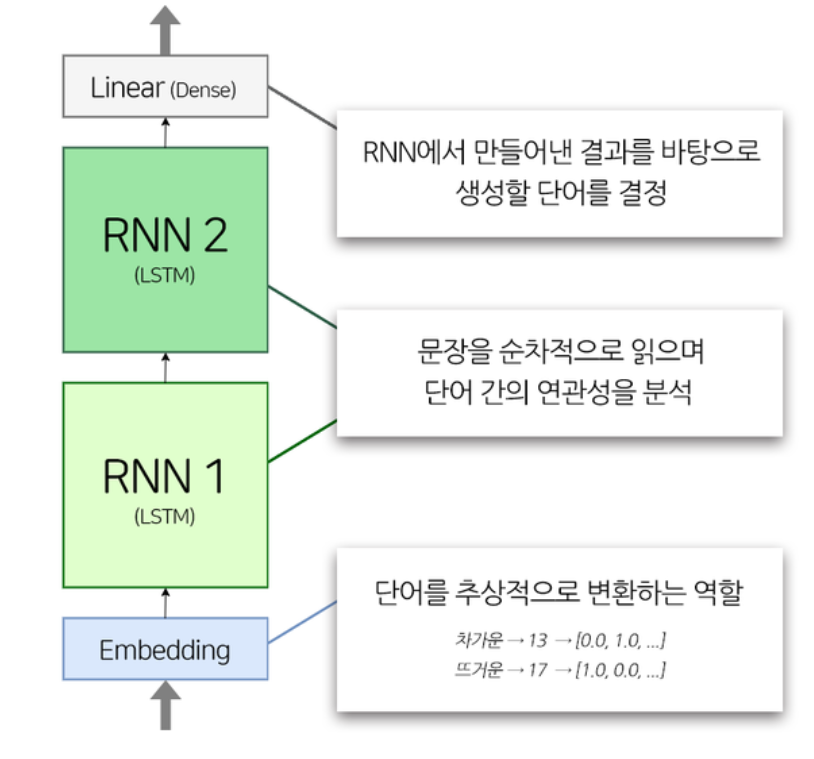

In [17]:
# Step 5. 인공지능 만들기
from tensorflow.keras.layers import Embedding, LSTM, Dense


class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        # 위의 도식화된 그림을 설계함
        self.embedding = Embedding(vocab_size, embedding_size)
        self.rnn_1 = LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = LSTM(hidden_size, return_sequences=True)
        self.linear = Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
#문장을 토큰으로 했을 때 15이므로 15로 구성
embedding_size = 15
hidden_size = 2048 # hidden size는 2048로


model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

# model.compile(loss=loss, optimizer=optimizer)

In [18]:
# 이 부분을 무조건 넣어야 한다.

# Sequentail 모델이나, Funtional API는 선언형(Define-and-Run)이므로 모델을 정의&인스턴스화한 단계에서 계산 그래프가 정적으로 구축된다. 
# 한편 Subclassing 모델은 명령형(Define-by-Run)이므로 실행한 단계에서 계산 그래프가 동적으로 구축되는 사양이다.

# 즉, 아직 실행하고 있지 않으므로, 계산 그래프가 구축되어있지 않아, 모델의 내용과 구성도가 출력되지 않은 것이다. 
# 그렇다면 추론을 1회 실행하여, 계산 그래프를 동적으로 작성하면 제대로 동작할 것이다.


# 데이터셋에서 데이터 한 배치만 불러오는 방법
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣는다.
model(src_sample)



<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 6.79035584e-05,  1.68821025e-05, -3.55949601e-06, ...,
          2.44628463e-05, -1.12155840e-05,  3.45759254e-05],
        [ 6.14916717e-05,  5.93245059e-05, -2.82740184e-05, ...,
          1.92320749e-05, -3.15577490e-05,  1.61833486e-05],
        [ 3.53405303e-05,  8.23284572e-05, -8.41249857e-05, ...,
          7.34587229e-05, -9.50971153e-05,  2.19824524e-05],
        ...,
        [ 1.58534051e-04,  9.84627768e-05,  4.81547650e-05, ...,
         -2.91703269e-04,  1.41562532e-05,  2.35152984e-04],
        [ 1.97553556e-04,  8.68895513e-05,  6.91352834e-05, ...,
         -3.12810094e-04,  1.31407560e-05,  2.61496578e-04],
        [ 2.32541090e-04,  7.44255958e-05,  8.23988157e-05, ...,
         -3.30789306e-04,  4.89478316e-06,  2.82751542e-04]],

       [[ 1.51293316e-05, -2.78814855e-06,  2.02192641e-05, ...,
         -2.79857450e-05,  1.48541985e-05,  2.59918306e-05],
        [ 4.27200248e-05, -6.28904672e-06,  4

In [19]:
model.summary()

Model: "text_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  180015    
                                                                 
 lstm (LSTM)                 multiple                  16908288  
                                                                 
 lstm_1 (LSTM)               multiple                  33562624  
                                                                 
 dense (Dense)               multiple                  24590049  
                                                                 
Total params: 75,240,976
Trainable params: 75,240,976
Non-trainable params: 0
_________________________________________________________________


In [20]:
# optimizer와 loss는 향후 나온다.

# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer) # 옵티마이저 변환 가능
model.fit(dataset, epochs=10)


Epoch 1/10
730/730 [==============================] - 347s 471ms/step - loss: 3.0428
Epoch 2/10
730/730 [==============================] - 356s 488ms/step - loss: 2.6485
Epoch 3/10
730/730 [==============================] - 357s 488ms/step - loss: 2.4092
Epoch 4/10
730/730 [==============================] - 356s 487ms/step - loss: 2.1769
Epoch 5/10
730/730 [==============================] - 356s 488ms/step - loss: 1.9467
Epoch 6/10
730/730 [==============================] - 356s 488ms/step - loss: 1.7299
Epoch 7/10
730/730 [==============================] - 357s 488ms/step - loss: 1.5336
Epoch 8/10
730/730 [==============================] - 356s 487ms/step - loss: 1.3605
Epoch 9/10
730/730 [==============================] - 357s 488ms/step - loss: 1.2119
Epoch 10/10
730/730 [==============================] - 357s 488ms/step - loss: 1.0857


In [80]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환한다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index[""]

    # 단어 하나씩 예측해 문장을 만든다.
    #    1. 입력받은 문장의 텐서를 입력한다.
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아낸다.
    #    3. 2에서 예측된 word index를 문장 뒤에 붙인다.
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마친다.
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환한다.
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [81]:
# print(preprocess_sentence(raw_corpus[0]))

generate_text(model, tokenizer, init_sentence="<start> i love")

KeyError: ignored

총평 : 처음으로 결과가 나오지 않은 exp이다.
거의 밤을 새다시피 해서 했는데 마지막에 KeyError가 생겨서 결과물을 도출할수가 없었다.
여기에서 검색을 하고 트러블슈팅을 한다고 5시간 이상을 소요하였다.

추측하건대, 
for idx in tokenizer.index_word:
print(idx, ":", tokenizer.index_word[idx])

if idx >= 10: break

여기에서 출력값에서 <start>, <end>가 나오지 않았는데, 전처리 과정에서 문제가 발생한 것으로 보인다.
자연어처리가 어렵다고도 들었는데 난이도는 최상급이었고 Hiddenlayer의 사이즈를 2048로 높여서 진행했음해서 그런지 모델학습시에 validaiton loss 값 자체는 1.08때까지 떨어졌다.

하지만, 결과물 자체가 생성되지 않아서 과정만 남겨놓은 찝찝한 과제였다.

전반적으로 Exp에 대한 설명도 친절한 편이 아니었다.
